In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision import transforms
from ipywidgets import interact, IntSlider, fixed
from IPython.display import display
from PIL import Image
from skimage.transform import resize
from keras.preprocessing import image
# Assuming utils, evaluation, and explanations modules are custom and present in your project
from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE
import shap 
cudnn.benchmark = True
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import json
import torch
from torchvision.models import resnet50
from torch.nn.functional import softmax
from PIL import Image
from torchvision import transforms
from morphology import *

In [2]:
# Load black box model for explanations
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False

model = nn.DataParallel(model)

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
import tensorflow as tf

# getting ImageNet 1000 class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]
    
img_path = 'tnc_54897705.jpg'
img = read_tensor(img_path)

def predict_with_resnet50_pytorch(image_tensor, target_class=1):
    # Ensure the model is in evaluation mode
    model = resnet50(pretrained=True)
    model = model.eval()
    
    # Ensure the tensor is in the correct shape [C, H, W] with C=3, H=W=224
    # Check for batch dimension and add if missing
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)
    
    # Perform prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        percentage = probabilities[0][target_class].item() * 100
        top_probabilities, top_classes = torch.topk(probabilities, k=3)
    # Convert output probabilities to softmax probabilities
    
    # Decode predictions to find the top 3 predictions
    return f'Prediction for class {target_class} = {percentage:.2f}%', top_probabilities[0], top_classes[0]

predicted_classes, top_probabilities, top_classes = predict_with_resnet50_pytorch(img)

# Assuming get_class_name is a function to get class names from class indices
# You'll need to define or import this function
print(predicted_classes)
for i in range(len(top_classes)):
    class_name = get_class_name(top_classes[i].item())
    percentage = top_probabilities[i].item() * 100
    print(f'Top {i+1} class: {class_name}, Probability: {percentage:.2f}%')
    
print(predicted_classes)
get_class_name(top_classes[0].item())
target_class = top_classes[0].item()

c:\Users\eagua\anaconda3\envs\torch_cuda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


Prediction for class 1 = 0.00%
Top 1 class: tiger shark, Probability: 99.42%
Top 2 class: great white shark, Probability: 0.40%
Top 3 class: hammerhead, Probability: 0.17%
Prediction for class 1 = 0.00%


In [4]:
'''
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1
        print(self.masks.shape)

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)  # Add batch dimension
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        pass_count = 0
        fail_count = 0
        self.generate_masks(N, s, p1)
        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        for i in range(N): 
            #is_pass = (i % 2 == 0 and pass_count < N // 2) or (i % 2 != 0 and fail_count >= N // 2)
            
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                kernel_size = 3
                print(f"Generating Mutant Number#{i+1}/ It should be Pass{N}")

            else:
                target_score = threshold
                tag = "Fail"
                #pass_count += 1
                kernel_size = 3
                print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            #mask = self.masks[i]
            while not found:
                #print(self.masks.shape)


                masked_image = torch.mul(self.masks[i], img_tensor) # Add batch dimension
                print(masked_image.shape)  # Add batch dimension
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100

                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    print(f"Mutant #{i+1} found with score: {pred_score:.2f}")
                    best_score = pred_score
                    best_mutant = masked_image
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        print(f"mask before dilation: {self.masks[i].shape}")
                        self.masks = dilation(self.masks[i])
                        print(f"mask before after: {self.masks[i].shape}")
                        kernel_size += 3
                        print(f"Kernel size: {kernel_size}, Pred score: {pred_score}, Dilation!")

                    elif tag == "Fail" and pred_score >= target_score:
                        self.masks = erosion(self.masks[i])
                        print(f"Kernel size: {kernel_size}, Pred score: {pred_score}, Erosion!")
                        kernel_size += 3
                    
            sampled_tensor[i] = best_mutant.squeeze(0)  # Remove the batch dimension
            scores[i] = best_score
        
        return sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))

sampled_tensor, scores = explainer.generate_mutants(img, N=4, s=8, p1=0.2, target_class=target_class)
'''

'\nimport numpy as np\nimport torch\nimport torch.nn.functional as F\nfrom tqdm import tqdm\nfrom skimage.transform import resize\nfrom torchvision.models import resnet50\n\nclass RISE:\n    def __init__(self, model, input_size):\n        self.model = model\n        self.input_size = input_size\n\n    def generate_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        self.masks = np.empty((N, *self.input_size))\n\n        for i in tqdm(range(N), desc=\'Generating filters\'):\n            x = np.random.randint(0, cell_size[0])\n            y = np.random.randint(0, cell_size[1])\n            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode=\'reflect\',\n                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]\n        self.masks = self.masks.reshape(-1, 1,

Buenardo

In [5]:
#BUENAZO
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from skimage.transform import resize
from torchvision.models import resnet50
from torch.nn import Module

class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def generate_support_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        support_masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N)):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            support_masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                            anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        support_masks = support_masks.reshape(-1, 1, *self.input_size)
        support_masks = torch.from_numpy(support_masks).float().cuda()
        return support_masks


    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        self.generate_masks(N, s, p1)
        
        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)

        for i in range(N):
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                print(f"Generating Mutant Number#{i+1}/ It should be Pass {N}")
            else:
                target_score = threshold
                tag = "Fail"
                print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            mask = self.masks[i].clone()  # Clone the mask to prevent in-place modifications
            beta = 5
            erosion_count = 0
            dilation_count = 0
            mask2 = self.masks[i].clone()
            while not found:
                masked_image = torch.mul(mask, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100
                
                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    #print(f"Mutant #{i+1} found with score: {pred_score:.2f}")
                    best_score = pred_score
                    best_mutant = masked_image
                    sampled_tensor[i] = best_mutant[-1].squeeze(0)
                    scores[i] = best_score
                    self.masks[i] = mask[-1]
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        mask = dilation(mask)  # Apply dilation to the cloned mask
                        print('dilation')
                        dilation_count += 1
                        #print(f"Kernel size: {beta}, Pred score: {pred_score}, Dilation!")
                        beta += 5
                        if dilation_count >= 15:
  
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            dilation_count = 0
                    else:
                        mask = erosion(mask)  # Apply erosion to the cloned mask
                        erosion_count += 1
                        print('erosion')
                        beta += 5
                        if erosion_count >= 15:
                            print("Generando otra mascara BC erosion fallo")
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            erosion_count = 0  # Reset the erosion count
        
        masks = self.masks
        return masks, threshold, sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))
N = 200
# Assuming img and target_class are defined
masks, threshold, sampled_tensor, scores = explainer.generate_mutants(img, N, s=5, p1=0.4, target_class=target_class)


Maximum prediction score: 99.41731095314026
Threshold: 49.70865547657013


Generating filters: 100%|██████████| 200/200 [00:00<00:00, 771.17it/s]


Generating Mutant Number#1/ It should be Pass 200
Generating Fail Mutant #2/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


erosion
erosion
Generating Mutant Number#3/ It should be Pass 200
Generating Fail Mutant #4/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 870.01it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1050.41it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#5/ It should be Pass 200
Generating Fail Mutant #6/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generating Mutant Number#7/ It should be Pass 200
Generating Fail Mutant #8/200 It should be a Fail
Generating Mutant Number#9/ It should be Pass 200
Generating Fail Mutant #10/200 It should be a Fail
erosion
erosion
erosion
Generating Mutant Number#11/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #12/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#13/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation


dilation
dilation
Generating Fail Mutant #14/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#15/ It should be Pass 200


Generating Fail Mutant #16/200 It should be a Fail
Generating Mutant Number#17/ It should be Pass 200
Generating Fail Mutant #18/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 665.02it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#19/ It should be Pass 200
Generating Fail Mutant #20/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#21/ It should be Pass 200
Generating Fail Mutant #22/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#23/ It should be Pass 200
Generating Fail Mutant #24/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.36it/s]

erosion
erosion
Generating Mutant Number#25/ It should be Pass 200
dilation
Generating Fail Mutant #26/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 665.34it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.63it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


erosion
Generating Mutant Number#27/ It should be Pass 200
Generating Fail Mutant #28/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 497.60it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#29/ It should be Pass 200
Generating Fail Mutant #30/200 It should be a Fail
Generating Mutant Number#31/ It should be Pass 200
Generating Fail Mutant #32/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 471.06it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


erosion
Generating Mutant Number#33/ It should be Pass 200
Generating Fail Mutant #34/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 871.27it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generating Mutant Number#35/ It should be Pass 200
Generating Fail Mutant #36/200 It should be a Fail
Generating Mutant Number#37/ It should be Pass 200
Generating Fail Mutant #38/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.67it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.36it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#39/ It should be Pass 200
Generating Fail Mutant #40/200 It should be a Fail
erosion
erosion
erosion
Generating Mutant Number#41/ It should be Pass 200
Generating Fail Mutant #42/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.02it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 664.60it/s]

erosion
erosion
erosion
erosion
Generating Mutant Number#43/ It should be Pass 200
Generating Fail Mutant #44/200 It should be a Fail
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.69it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#45/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #46/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.31it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#47/ It should be Pass 200
Generating Fail Mutant #48/200 It should be a Fail
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 554.22it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.80it/s]


erosion
erosion
Generating Mutant Number#49/ It should be Pass 200
Generating Fail Mutant #50/200 It should be a Fail
Generating Mutant Number#51/ It should be Pass 200
Generating Fail Mutant #52/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#53/ It should be Pass 200
Generating Fail Mutant #54/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]

Generating Mutant Number#55/ It should be Pass 200
Generating Fail Mutant #56/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#57/ It should be Pass 200
dilation
dilation
dilation
dilation
Generating Fail Mutant #58/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]

Generating Mutant Number#59/ It should be Pass 200
Generating Fail Mutant #60/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#61/ It should be Pass 200
Generating Fail Mutant #62/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 664.92it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 886.00it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#63/ It should be Pass 200
Generating Fail Mutant #64/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#65/ It should be Pass 200
Generating Fail Mutant #66/200 It should be a Fail
erosion
erosion
Generating Mutant Number#67/ It should be Pass 200
Generating Fail Mutant #68/200 It should be a Fail
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 501.05it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 613.65it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

Generating Mutant Number#69/ It should be Pass 200
Generating Fail Mutant #70/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 662.50it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.07it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generating Mutant Number#71/ It should be Pass 200
dilation
dilation
Generating Fail Mutant #72/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#73/ It should be Pass 200
Generating Fail Mutant #74/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.91it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]

Generating Mutant Number#75/ It should be Pass 200


Generating Fail Mutant #76/200 It should be a Fail
Generating Mutant Number#77/ It should be Pass 200
Generating Fail Mutant #78/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#79/ It should be Pass 200
Generating Fail Mutant #80/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#81/ It should be Pass 200
Generating Fail Mutant #82/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]

erosion
erosion
erosion
Generating Mutant Number#83/ It should be Pass 200
Generating Fail Mutant #84/200 It should be a Fail
Generating Mutant Number#85/ It should be Pass 200
Generating Fail Mutant #86/200 It should be a Fail
erosion
erosion
erosion
Generating Mutant Number#87/ It should be Pass 200
Generating Fail Mutant #88/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#89/ It should be Pass 200


Generating Fail Mutant #90/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.86it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 476.73it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 996.98it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.36it/s]


Generating Mutant Number#91/ It should be Pass 200
Generating Fail Mutant #92/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 721.29it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

erosion
Generating Mutant Number#93/ It should be Pass 200
Generating Fail Mutant #94/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.62it/s]

erosion
erosion
Generating Mutant Number#95/ It should be Pass 200
Generating Fail Mutant #96/200 It should be a Fail
Generating Mutant Number#97/ It should be Pass 200
Generating Fail Mutant #98/200 It should be a Fail
Generating Mutant Number#99/ It should be Pass 200
Generating Fail Mutant #100/200 It should be a Fail
erosion
erosion
erosion
Generating Mutant Number#101/ It should be Pass 200


Generating Fail Mutant #102/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1002.22it/s]

erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#103/ It should be Pass 200
Generating Fail Mutant #104/200 It should be a Fail
erosion
erosion
Generating Mutant Number#105/ It should be Pass 200
Generating Fail Mutant #106/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]


erosion
Generating Mutant Number#107/ It should be Pass 200
Generating Fail Mutant #108/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


Generating Mutant Number#109/ It should be Pass 200
Generating Fail Mutant #110/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#111/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #112/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#113/ It should be Pass 200
Generating Fail Mutant #114/200 It should be a Fail
Generating Mutant Number#115/ It should be Pass 200
Generating Fail Mutant #116/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.27it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


Generating Mutant Number#117/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #118/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]

Generating Mutant Number#119/ It should be Pass 200
Generating Fail Mutant #120/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 664.71it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 992.97it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.56it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#121/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #122/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 664.39it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 996.75it/s]

Generating Mutant Number#123/ It should be Pass 200
Generating Fail Mutant #124/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 664.08it/s]

Generating Mutant Number#125/ It should be Pass 200
Generating Fail Mutant #126/200 It should be a Fail
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#127/ It should be Pass 200
Generating Fail Mutant #128/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.02it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#129/ It should be Pass 200
Generating Fail Mutant #130/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]


Generating Mutant Number#131/ It should be Pass 200
Generating Fail Mutant #132/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.08it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1000.55it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.97it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Generating Mutant Number#133/ It should be Pass 200
Generating Fail Mutant #134/200 It should be a Fail
erosion
erosion
erosion
Generating Mutant Number#135/ It should be Pass 200
Generating Fail Mutant #136/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.57it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#137/ It should be Pass 200
Generating Fail Mutant #138/200 It should be a Fail
erosion
erosion
Generating Mutant Number#139/ It should be Pass 200
Generating Fail Mutant #140/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.88it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.14it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]

Generating Mutant Number#141/ It should be Pass 200


Generating Fail Mutant #142/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#143/ It should be Pass 200
Generating Fail Mutant #144/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.49it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 486.24it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 399.15it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 331.57it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#145/ It should be Pass 200
Generating Fail Mutant #146/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#147/ It should be Pass 200
Generating Fail Mutant #148/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 996.27it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#149/ It should be Pass 200
Generating Fail Mutant #150/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 369.57it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 399.38it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#151/ It should be Pass 200
Generating Fail Mutant #152/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#153/ It should be Pass 200
Generating Fail Mutant #154/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.64it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.67it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 993.20it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#155/ It should be Pass 200
Generating Fail Mutant #156/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.64it/s]

erosion
Generating Mutant Number#157/ It should be Pass 200
Generating Fail Mutant #158/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#159/ It should be Pass 200


Generating Fail Mutant #160/200 It should be a Fail
erosion
erosion
Generating Mutant Number#161/ It should be Pass 200
Generating Fail Mutant #162/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.17it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


Generating Mutant Number#163/ It should be Pass 200
Generating Fail Mutant #164/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]

erosion
erosion
erosion
erosion
Generating Mutant Number#165/ It should be Pass 200
Generating Fail Mutant #166/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.27it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 886.75it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.74it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]

erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 640.74it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.16it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.10it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

erosion


Generating Mutant Number#167/ It should be Pass 200
Generating Fail Mutant #168/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 498.79it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]


Generating Mutant Number#169/ It should be Pass 200
Generating Fail Mutant #170/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]


Generating Mutant Number#171/ It should be Pass 200
Generating Fail Mutant #172/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 331.70it/s]

Generating Mutant Number#173/ It should be Pass 200
Generating Fail Mutant #174/200 It should be a Fail
Generating Mutant Number#175/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation


dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #176/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 998.64it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


Generating Mutant Number#177/ It should be Pass 200
Generating Fail Mutant #178/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

erosion
erosion
Generating Mutant Number#179/ It should be Pass 200
Generating Fail Mutant #180/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#181/ It should be Pass 200
Generating Fail Mutant #182/200 It should be a Fail
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.51it/s]


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#183/ It should be Pass 200
Generating Fail Mutant #184/200 It should be a Fail
Generating Mutant Number#185/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #186/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

Generating Mutant Number#187/ It should be Pass 200


Generating Fail Mutant #188/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 499.98it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 1001.03it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 527.85it/s]


Generating Mutant Number#189/ It should be Pass 200
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
dilation
Generating Fail Mutant #190/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#191/ It should be Pass 200
Generating Fail Mutant #192/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#193/ It should be Pass 200
Generating Fail Mutant #194/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
Generating Mutant Number#195/ It should be Pass 200
dilation
dilation
Generating Fail Mutant #196/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 500.39it/s]

erosion


erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


Generating Mutant Number#197/ It should be Pass 200
Generating Fail Mutant #198/200 It should be a Fail
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 929.79it/s]

erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion
erosion


erosion
erosion
erosion
erosion
erosion
erosion
Generando otra mascara BC erosion fallo


100%|██████████| 1/1 [00:00<00:00, 999.60it/s]


erosion
erosion
Generating Mutant Number#199/ It should be Pass 200
Generating Fail Mutant #200/200 It should be a Fail
erosion
erosion
erosion
erosion


In [6]:
'''
class RISE:
    def __init__(self, model, input_size):
        self.model = model
        self.input_size = input_size

    def generate_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = N
        self.p1 = p1

    def generate_support_masks(self, N, s, p1):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        support_masks = np.empty((N, *self.input_size))

        for i in range(N):
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            support_masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                            anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        support_masks = support_masks.reshape(-1, 1, *self.input_size)
        support_masks = torch.from_numpy(support_masks).float().cuda()
        return support_masks

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def generate_mutants(self, img_tensor, N, s, p1, target_class):
        img_tensor = img_tensor.cuda()
        self.model.eval()
        
        with torch.no_grad():
            output = self.model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            max_pred_score = probabilities[0][target_class].item() * 100

        threshold = max_pred_score / 2
        print(f'Maximum prediction score: {max_pred_score}')
        print(f'Threshold: {threshold}')

        sampled_tensor = torch.empty((N, *img_tensor.shape), device=img_tensor.device)
        scores = torch.empty(N, device=img_tensor.device)
        self.generate_masks(N, s, p1)
        
        dilation = Dilation2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)
        erosion = Erosion2d(1, 1, kernel_size=3, soft_max=False, beta=5).to(img_tensor.device)

        for i in range(N):
            if i % 2 == 0:
                target_score = threshold
                tag = "Pass"
                print(f"Generating Mutant Number#{i+1}/ It should be Pass {N}")
            else:
                target_score = threshold
                tag = "Fail"
                print(f"Generating Fail Mutant #{i+1}/{N} It should be a Fail")

            found = False
            mask = self.masks[i].clone()  # Clone the mask to prevent in-place modifications
            beta = 5
            erosion_count = 0
            dilation_count = 0
            
            while not found:
                masked_image = torch.mul(mask, img_tensor)
                with torch.no_grad():
                    output = self.model(masked_image)
                    probabilities = F.softmax(output, dim=1)
                    pred_score = probabilities[:, target_class].max().item() * 100
                
                if (tag == "Pass" and pred_score >= target_score) or (tag == "Fail" and pred_score < target_score):
                    found = True
                    best_score = pred_score
                    best_mutant = masked_image
                    sampled_tensor[i] = best_mutant[-1].squeeze(0)
                    scores[i] = best_score
                    self.masks[i] = mask[-1]
                else:
                    if tag == "Pass" and pred_score <= target_score:
                        mask = dilation(mask)  # Apply dilation to the cloned mask
                        dilation_count += 1
                        beta += 5
                        if dilation_count >= 15:
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            dilation_count = 0
                    else:
                        mask = erosion(mask)  # Apply erosion to the cloned mask
                        erosion_count += 1
                        beta += 5
                        if erosion_count >= 15:
                            #print("Generating another mask because erosion failed")
                            new_mask = self.generate_support_masks(1, s, p1)
                            beta = 3
                            mask = new_mask
                            erosion_count = 0  # Reset the erosion count
        
        masks = self.masks
        return masks, threshold, sampled_tensor, scores.cpu().tolist()

def get_class_name(class_idx):
    labels = np.loadtxt('synset_words.txt', str, delimiter='\t')
    print(f"Class index: {class_idx}")
    print(f"Total classes: {len(labels)}")
    return ' '.join(labels[class_idx].split(',')[0].split()[1:])

# Usage example
model = resnet50(pretrained=True).cuda()
explainer = RISE(model, (224, 224))
N = 250
# Assuming img and target_class are defined
masks, threshold, sampled_tensor, scores = explainer.generate_mutants(img, N, s=10, p1=0.1, target_class=target_class)
'''

'\nclass RISE:\n    def __init__(self, model, input_size):\n        self.model = model\n        self.input_size = input_size\n\n    def generate_masks(self, N, s, p1):\n        cell_size = np.ceil(np.array(self.input_size) / s)\n        up_size = (s + 1) * cell_size\n\n        grid = np.random.rand(N, s, s) < p1\n        grid = grid.astype(\'float32\')\n\n        self.masks = np.empty((N, *self.input_size))\n\n        for i in tqdm(range(N), desc=\'Generating filters\'):\n            x = np.random.randint(0, cell_size[0])\n            y = np.random.randint(0, cell_size[1])\n            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode=\'reflect\',\n                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]\n        self.masks = self.masks.reshape(-1, 1, *self.input_size)\n        self.masks = torch.from_numpy(self.masks).float().cuda()\n        self.N = N\n        self.p1 = p1\n\n    def generate_support_masks(self, N, s

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, fixed
import torch  # Assuming the mutants tensor is a PyTorch tensor

def visualize_single_mutant(mutants, scores, index):
    """
    Visualize a single mutant image with its score.
    
    Parameters:
    - mutants: Tensor of mutant images.
    - scores: List or array of scores corresponding to the mutant images.
    - index: Index of the mutant image to visualize.
    """
    mutant_image = mutants[index].detach().squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Squeeze and permute dimensions
    plt.figure(figsize=(5, 5))
    plt.imshow(mutant_image)
    plt.title(f"Mutant {index+1}\n{scores[index]:.2f}%")
    plt.axis('off')
    plt.show()

# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant, 
         mutants=fixed(sampled_tensor), 
         scores=fixed(scores), 
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=199), Output()), _dom_classes=('widg…

In [8]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
def unnormalize(tensor, mean, std):
    """
    Unnormalizes a tensor using the specified mean and std.
    """
    mean = torch.tensor(mean, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, device=tensor.device).view(1, 3, 1, 1)
    tensor = tensor * std + mean
    return tensor.clamp(0, 1)

def rgb_to_grayscale(tensor):
    """
    Converts RGB images to grayscale by applying the standard luminosity method.
    """
    r, g, b = tensor[:, 0, :, :], tensor[:, 1, :, :], tensor[:, 2, :, :]
    grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return grayscale.unsqueeze(1)  # Maintain the batch and channel dimension

mean = [0.485, 0.456, 0.406]  # ImageNet mean
std = [0.229, 0.224, 0.225]   # ImageNet std
sampled_tensor = unnormalize(sampled_tensor, mean, std)
sampled_tensor = TF.rgb_to_grayscale(sampled_tensor)


# Example tensor and scores (replace these with your actual data)
num_mutants = sampled_tensor.shape[0]
interact(visualize_single_mutant, 
         mutants=fixed(sampled_tensor), 
         scores=fixed(scores), 
         index=IntSlider(min=0, max=num_mutants-1, step=1, description='Mutant Index:'));

sampled_tensor.shape
img = unnormalize(img, mean, std)
img = TF.rgb_to_grayscale(img)
img = img.repeat(N, 1, 1, 1)
print(img.shape)

interactive(children=(IntSlider(value=0, description='Mutant Index:', max=199), Output()), _dom_classes=('widg…

torch.Size([200, 1, 224, 224])


In [9]:
'''
def calculate_relevance_scores(sampled_tensor, N, scores, threshold, device='cuda'):

    # Move tensor to device
    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)
    sampled_tensor = sampled_tensor.to(device)
    
    scores = torch.tensor(scores, device=device)
    # Determine the dimensions of the images
    _, C, H, W = sampled_tensor.shape
    
    # Initialize the counters for each pixel
    Ep = torch.zeros((H, W), dtype=torch.float, device=device)
    Np = torch.zeros((H, W), dtype=torch.float, device=device)
    Ef = torch.zeros((H, W), dtype=torch.float, device=device)
    Nf = torch.zeros((H, W), dtype=torch.float, device=device)
    DX = N/2

    # Calculate the masks for the conditions
    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero
    passed_mask = scores > threshold  # Prediction passed
    failed_mask = scores <= threshold  # Prediction failed

    # Iterate over each batch of the tensor
    for i in range(sampled_tensor.shape[0]):
        current_image = sampled_tensor[i].squeeze()       # Shape: [224, 224]
        current_executed_mask = executed_mask[i]          # Shape: [224, 224]
        current_mask = explainer.masks[i].squeeze()       # Shape: [224, 224]
        
        # Check the score against the threshold
        if scores[i] > threshold:
            Ep += (scores[i] * current_mask) / DX
        else:
            Ef += (scores[i] * current_mask) / DX
    

    pixel_indices = [(i, j) for i in range(224) for j in range(224)]
    Ep_values = [Ep[i, j].item() for i, j in pixel_indices]
    Ef_values = [Ef[i, j].item() for i, j in pixel_indices]
            # Debugging print statements
    print(f"Mutant {i}: Score = {scores[i].item()}")
    print(f"Executed Mask Sum = {current_executed_mask.sum().item()}")
    print(f"Current Image Sum = {current_image.sum(dim=0).sum().item()}")
    print(f"Ep Sum = {Ep.sum().item()}")
    print(f"Np Sum = {Np.sum().item()}")
    print(f"Ef Sum = {Ef.sum().item()}")
    print(f"Nf Sum = {Nf.sum().item()}")
    #Ep = Ep/2
    #Ef = Ef/2
    Ep = 
    Np = DX - Ep
    Nf = DX - Ef
    # Calculate the relevance scores
    relevance_scores = torch.zeros((H, W, 4), dtype=torch.float, device=device)
    relevance_scores[:, :, 0] = Ep
    relevance_scores[:, :, 1] = Np
    relevance_scores[:, :, 2] = Ef
    relevance_scores[:, :, 3] = Nf
    
    return relevance_scores

# Extract the second dimension, which contains class labels


relevance_scores = calculate_relevance_scores(sampled_tensor, N, scores, threshold)

print(scores)
print(sampled_tensor.shape)
# Convert relevance_scores to a readable format
relevance_scores_np = relevance_scores.detach().cpu().numpy()

# Flatten the H and W dimensions to make it easier to print
H, W, _ = relevance_scores_np.shape
flattened_scores = relevance_scores_np.reshape(H * W, 4)

# Print the first 1000 pixels
for i in range(min(1000, flattened_scores.shape[0])):
    Ep, Np, Ef, Nf = flattened_scores[i]
    print(f'Pixel {i}: Ep={Ep:.4f}, Np={Np:.4f}, Ef={Ef:.4f}, Nf={Nf:.4f}')

'''

'\ndef calculate_relevance_scores(sampled_tensor, N, scores, threshold, device=\'cuda\'):\n\n    # Move tensor to device\n    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)\n    sampled_tensor = sampled_tensor.to(device)\n    \n    scores = torch.tensor(scores, device=device)\n    # Determine the dimensions of the images\n    _, C, H, W = sampled_tensor.shape\n    \n    # Initialize the counters for each pixel\n    Ep = torch.zeros((H, W), dtype=torch.float, device=device)\n    Np = torch.zeros((H, W), dtype=torch.float, device=device)\n    Ef = torch.zeros((H, W), dtype=torch.float, device=device)\n    Nf = torch.zeros((H, W), dtype=torch.float, device=device)\n    DX = N/2\n\n    # Calculate the masks for the conditions\n    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero\n    passed_mask = scores > threshold  # Prediction passed\n    failed_mask = scores <= threshold  # Prediction failed\n\n    # Iterate over each batch of the tenso

In [10]:
'''
def calculate_relevance_scores(sampled_tensor, mask, N, scores, threshold, device='cuda'):

    sampled_tensor = sampled_tensor.to(device)
    print(scores)
    scores = torch.tensor(scores, device=device)
    # Determine the dimensions of the images
    _, C, H, W = sampled_tensor.shape
    print(scores.shape)
    scores_reshaped = scores.view(-1, 1, 1, 1)
    # Initialize the counters for each pixel
    DX = N / 2

    # Separate the tensors based on the threshold
    pass_indices = scores > threshold
    fail_indices = scores <= threshold
    #Dividimos los tensores entre failure y pass

    executed_tensors = sampled_tensor * (mask * scores_reshaped) #De aqui sacaremos Ep y Ef
    not_executed_tensors = sampled_tensor * ((1 - mask) * scores_reshaped) #De aqui sacaremos Np y Nf


    e_pass_tensors = executed_tensors[pass_indices] #EP
    e_fail_tensors = executed_tensors[fail_indices] #EF
    #No activados
    n_pass_tensors = not_executed_tensors[pass_indices] #Np
    n_fail_tensors = not_executed_tensors[fail_indices] #Nf
    # Corresponding scores for pass and fail tensors

    Ep = e_pass_tensors.sum(dim=0) / DX
    Ef = e_fail_tensors.sum(dim=0) / DX
    Np = n_pass_tensors.sum(dim=0) / DX
    Nf = n_fail_tensors.sum(dim=0) / DX

    print(Ep.shape)
    print(Ep.shape)
    print(Np.shape)
    print(Nf.shape)

    return Ep, Ef, Np, Nf

# Example usage
Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N, scores, threshold)


# Flatten the results for printing
Ep_flat = Ep.view(-1).cpu().detach().numpy()
Ef_flat = Ef.view(-1).cpu().detach().numpy()
Np_flat = Np.view(-1).cpu().detach().numpy()
Nf_flat = Nf.view(-1).cpu().detach().numpy()

# Print the first 1000 pixels
for i in range(min(1000, Ep_flat.shape[0])):
    print(f'Pixel {i + 1}: Ep={Ep_flat[i]:.4f}, Np={Np_flat[i]:.4f}, Ef={Ef_flat[i]:.4f}, Nf={Nf_flat[i]:.4f}')

'''

"\ndef calculate_relevance_scores(sampled_tensor, mask, N, scores, threshold, device='cuda'):\n\n    sampled_tensor = sampled_tensor.to(device)\n    print(scores)\n    scores = torch.tensor(scores, device=device)\n    # Determine the dimensions of the images\n    _, C, H, W = sampled_tensor.shape\n    print(scores.shape)\n    scores_reshaped = scores.view(-1, 1, 1, 1)\n    # Initialize the counters for each pixel\n    DX = N / 2\n\n    # Separate the tensors based on the threshold\n    pass_indices = scores > threshold\n    fail_indices = scores <= threshold\n    #Dividimos los tensores entre failure y pass\n\n    executed_tensors = sampled_tensor * (mask * scores_reshaped) #De aqui sacaremos Ep y Ef\n    not_executed_tensors = sampled_tensor * ((1 - mask) * scores_reshaped) #De aqui sacaremos Np y Nf\n\n\n    e_pass_tensors = executed_tensors[pass_indices] #EP\n    e_fail_tensors = executed_tensors[fail_indices] #EF\n    #No activados\n    n_pass_tensors = not_executed_tensors[pass_in

In [11]:
def calculate_relevance_scores(sampled_tensor, mask, N, scores, threshold, device='cuda'):
    sampled_tensor = sampled_tensor.to(device)
    scores = torch.tensor(scores, device=device)
    _, C, H, W = sampled_tensor.shape
    scores_reshaped = scores.view(-1, 1, 1, 1)
    DX = N / 2

    pass_indices = scores > threshold
    fail_indices = scores <= threshold
    shape = (N, 1, 224, 224)
    tensor_ones = torch.ones(shape).to(device)
    reverse_mask = sampled_tensor - mask
    executed_tensors = sampled_tensor * mask 
    not_executed_tensors = tensor_ones * reverse_mask 

    e_pass_tensors = executed_tensors[pass_indices]
    e_fail_tensors = executed_tensors[fail_indices]
    n_pass_tensors = not_executed_tensors[pass_indices]
    n_fail_tensors = not_executed_tensors[fail_indices]

    Ep = e_pass_tensors.sum(dim=0) / DX
    Ef = e_fail_tensors.sum(dim=0) / DX
    Np = n_pass_tensors.sum(dim=0) / DX
    Nf = n_fail_tensors.sum(dim=0) / DX

    return Ep.cpu().detach().numpy(), Ef.cpu().detach().numpy(), Np.cpu().detach().numpy(), Nf.cpu().detach().numpy()

def calculate_ochiai(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(pixel):
    Ep, Np, Ef, Nf = pixel
    return (Ef/(Ef + Nf)) / ((Ef/(Ef + Nf)) + (Ep/(Ep + Np)))

def calculate_zoltar(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef / (Ef + Nf + Ep + ((10000 * Nf * Ep) / Ef))  

def calculate_wong1(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef - Ep

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

Ep, Ef, Np, Nf = calculate_relevance_scores(img, masks, N, scores, threshold)

# Flatten the results for calculating scores
flattened_scores = np.stack([Ep.flatten(), Np.flatten(), Ef.flatten(), Nf.flatten()], axis=1)

# Calculate scores
ochiai_scores = np.array([calculate_ochiai(pixel) for pixel in flattened_scores])
tarantula_scores = np.array([calculate_tarantula(pixel) for pixel in flattened_scores])
zoltar_scores = np.array([calculate_zoltar(pixel) for pixel in flattened_scores])
wong1_scores = np.array([calculate_wong1(pixel) for pixel in flattened_scores])

# Map scores to a specified range
mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarantula_scores = map_values_to_range(tarantula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)

# Select 1000 random pixels
random_indices = random.sample(range(len(zoltar_scores)), min(1000, len(zoltar_scores)))
random_ochiai_scores = mapped_ochiai_scores[random_indices]


C:\Users\eagua\AppData\Local\Temp\ipykernel_35760\1427434232.py:30: RuntimeWarning: invalid value encountered in sqrt
  return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))


In [12]:
'''
import torch

def calculate_relevance_scores(sampled_tensor, N, scores, threshold, device='cuda'):

    # Move tensor to device
    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)
    sampled_tensor = sampled_tensor.to(device)
    
    scores = torch.tensor(scores, device=device)
    # Determine the dimensions of the images
    _, C, H, W = sampled_tensor.shape
    
    # Initialize the counters for each pixel
    Ep = torch.zeros((H, W), dtype=torch.float, device=device)
    Ef = torch.zeros((H, W), dtype=torch.float, device=device)
    
    # Calculate the masks for the conditions
    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero

    # Iterate over each batch of the tensor
    for i in range(sampled_tensor.shape[0]):
        current_image = sampled_tensor[i].squeeze()       # Shape: [H, W]
        current_executed_mask = executed_mask[i]          # Shape: [H, W]
        current_mask = current_executed_mask.float()      # Convert to float for multiplication
        
        # Check the score against the threshold
        if scores[i] > threshold:
            Ep += current_mask
        else:
            Ef += current_mask

    # Optionally, you can convert the values to lists for further processing
    pixel_indices = [(i, j) for i in range(H) for j in range(W)]
    Ep_values = [Ep[i, j].item() for i, j in pixel_indices]
    Ef_values = [Ef[i, j].item() for i, j in pixel_indices]
    
    return Ep_values, Ef_values


Ep, Ef = calculate_relevance_scores(sampled_tensor, N, scores, threshold)
# Flatten the H and W dimensions to make it easier to print
H, W, _ = relevance_scores_np.shape
flattened_scores = relevance_scores_np.reshape(H * W, 4)

# Print the first 1000 pixels
for i in range(min(1000, flattened_scores.shape[0])):
    Ep, Np, Ef, Nf = flattened_scores[i]
    print(f'Pixel {i}: Ep={Ep:.4f}, Np={Np:.4f}, Ef={Ef:.4f}, Nf={Nf:.4f}')
'''

"\nimport torch\n\ndef calculate_relevance_scores(sampled_tensor, N, scores, threshold, device='cuda'):\n\n    # Move tensor to device\n    sampled_tensor = torch.squeeze(sampled_tensor, dim=1)\n    sampled_tensor = sampled_tensor.to(device)\n    \n    scores = torch.tensor(scores, device=device)\n    # Determine the dimensions of the images\n    _, C, H, W = sampled_tensor.shape\n    \n    # Initialize the counters for each pixel\n    Ep = torch.zeros((H, W), dtype=torch.float, device=device)\n    Ef = torch.zeros((H, W), dtype=torch.float, device=device)\n    \n    # Calculate the masks for the conditions\n    executed_mask = sampled_tensor.sum(dim=1) != 0  # Pixel executed if any channel is non-zero\n\n    # Iterate over each batch of the tensor\n    for i in range(sampled_tensor.shape[0]):\n        current_image = sampled_tensor[i].squeeze()       # Shape: [H, W]\n        current_executed_mask = executed_mask[i]          # Shape: [H, W]\n        current_mask = current_executed_mask

In [13]:
def calculate_ochiai(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))

def calculate_tarantula(pixel):
    Ep, Np, Ef, Nf = pixel
    return (Ef/(Ef + Nf)) / ((Ef/(Ef + Nf)) + (Ep/(Ep + Np)))

def calculate_zoltar(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ef/(Ef + Nf + Ep + ((10000*Nf*Ep)/Ef))  

def calculate_wong1(pixel):
    Ep, Np, Ef, Nf = pixel
    return Ep - Ef

ochiai_scores = np.array([calculate_ochiai(pixel) for pixel in flattened_scores])
tarauntula_scores = np.array([calculate_tarantula(pixel) for pixel in flattened_scores])
zoltar_scores = np.array([calculate_zoltar(pixel) for pixel in flattened_scores])
wong1_scores = np.array([calculate_wong1(pixel) for pixel in flattened_scores])

def map_values_to_range(values, target_min=0, target_max=100):
    src_min = values.min()
    src_max = values.max()
    return target_min + (values - src_min) * (target_max - target_min) / (src_max - src_min)

mapped_ochiai_scores = map_values_to_range(ochiai_scores)
mapped_tarauntula_scores = map_values_to_range(tarauntula_scores)
mapped_zoltar_scores = map_values_to_range(zoltar_scores)
mapped_wong1_scores = map_values_to_range(wong1_scores)

# Select 1000 random pixels

random_indices = random.sample(range(len(wong1_scores)), 1000)
random_ochiai_scores = wong1_scores[random_indices]

print(f" Ochiai Score pixel 1: {ochiai_scores[1]}")


 Ochiai Score pixel 1: 0.18826593458652496


C:\Users\eagua\AppData\Local\Temp\ipykernel_35760\1788983785.py:3: RuntimeWarning: invalid value encountered in sqrt
  return Ef / np.sqrt((Ef + Nf) * (Ef + Ep))


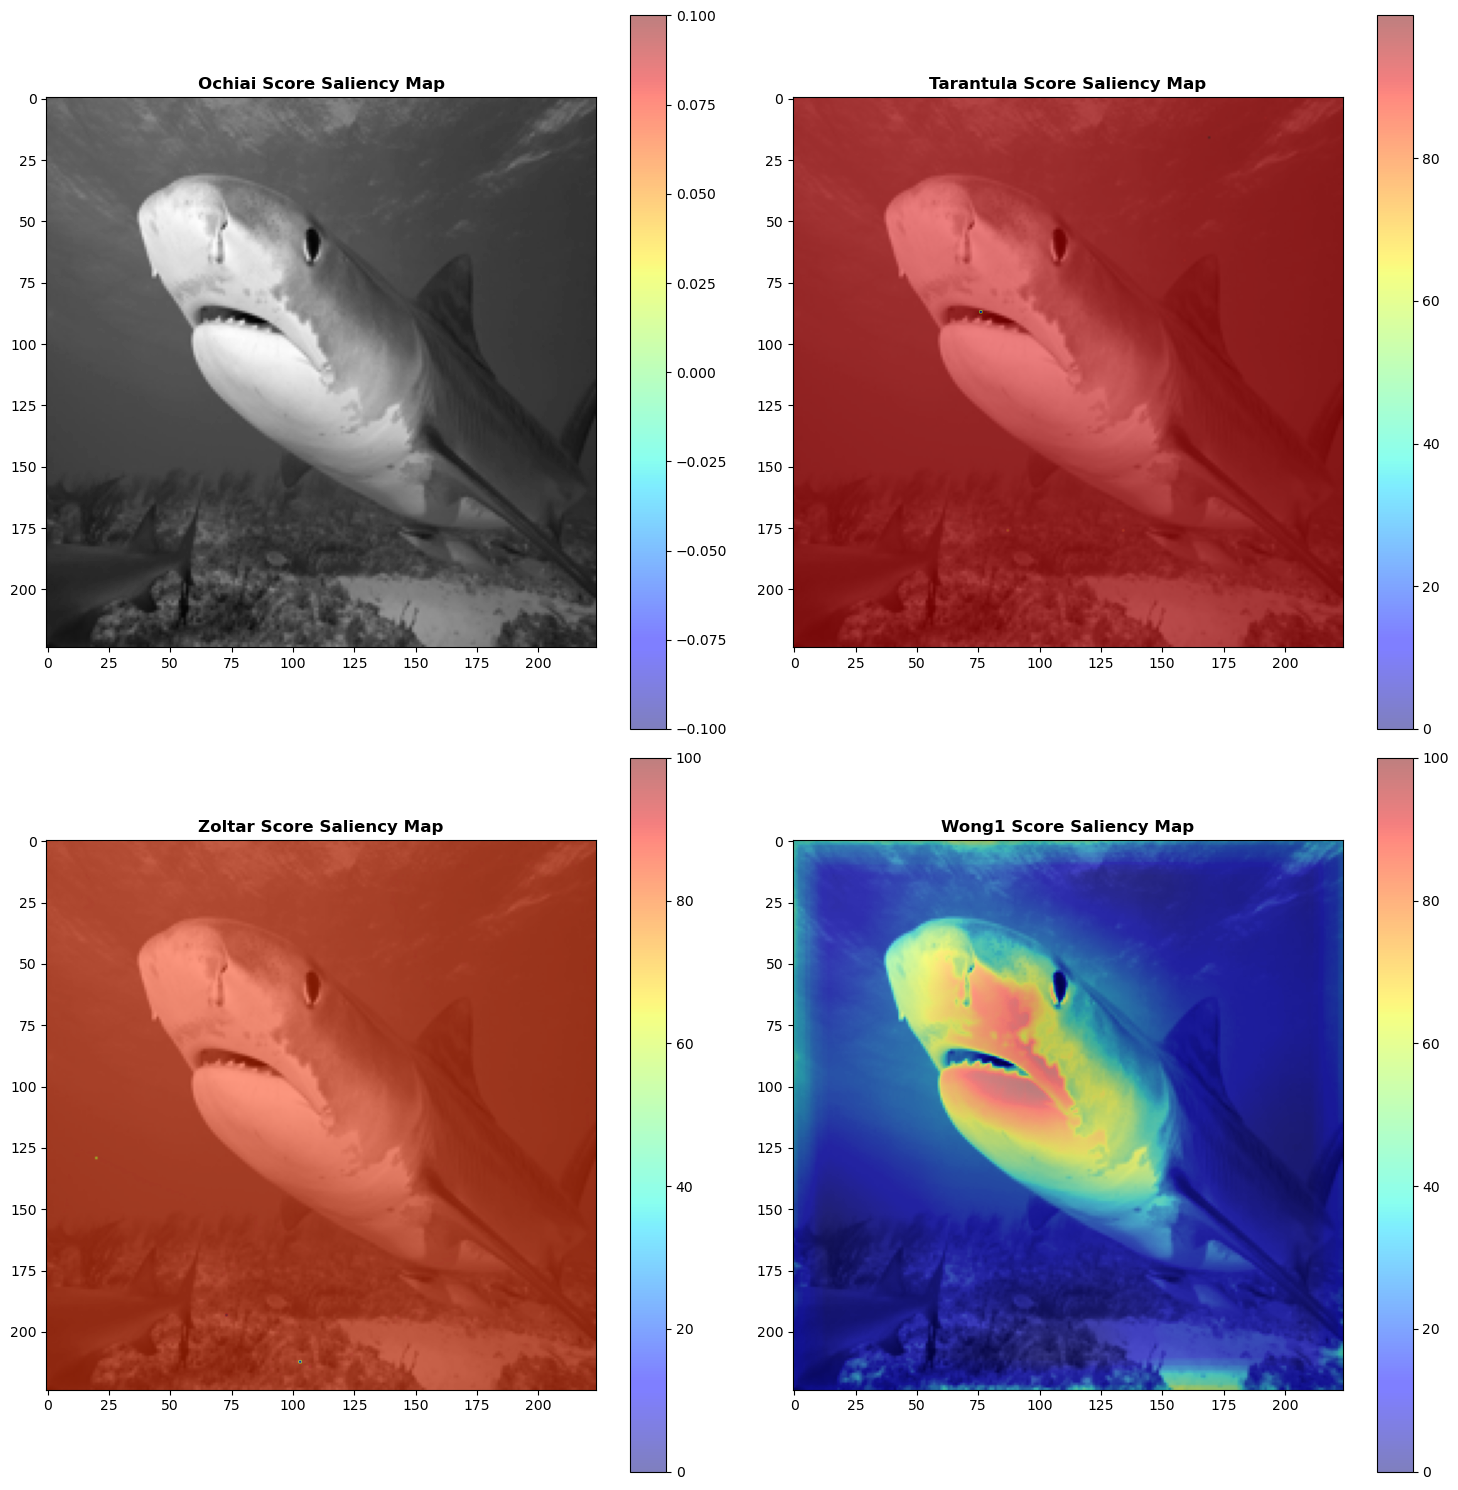

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarantula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')
    
    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)
    
    # Add a colorbar
    fig.colorbar(c, ax=ax)
    
    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()

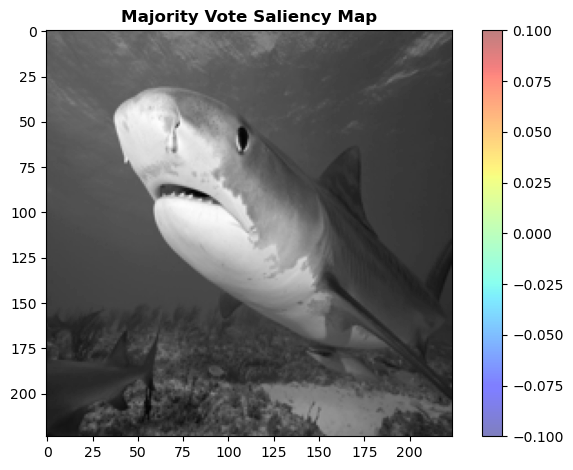

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)



# Define the extent
extent = [0, 224, 0, 224]

# Plot each map

# Stack the scores for majority voting
all_scores = np.stack((ochiai_map, tarantula_map, zoltar_map, wong1_map), axis=-1)

# Function to get majority vote
def majority_vote(scores):
    return np.average(scores)

# Apply majority voting
majority_scores = np.apply_along_axis(majority_vote, 2, all_scores)

# Reshape the majority scores to match the original image dimensions (not needed if already correct)
saliency_map = majority_scores

# Plot the majority vote saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()



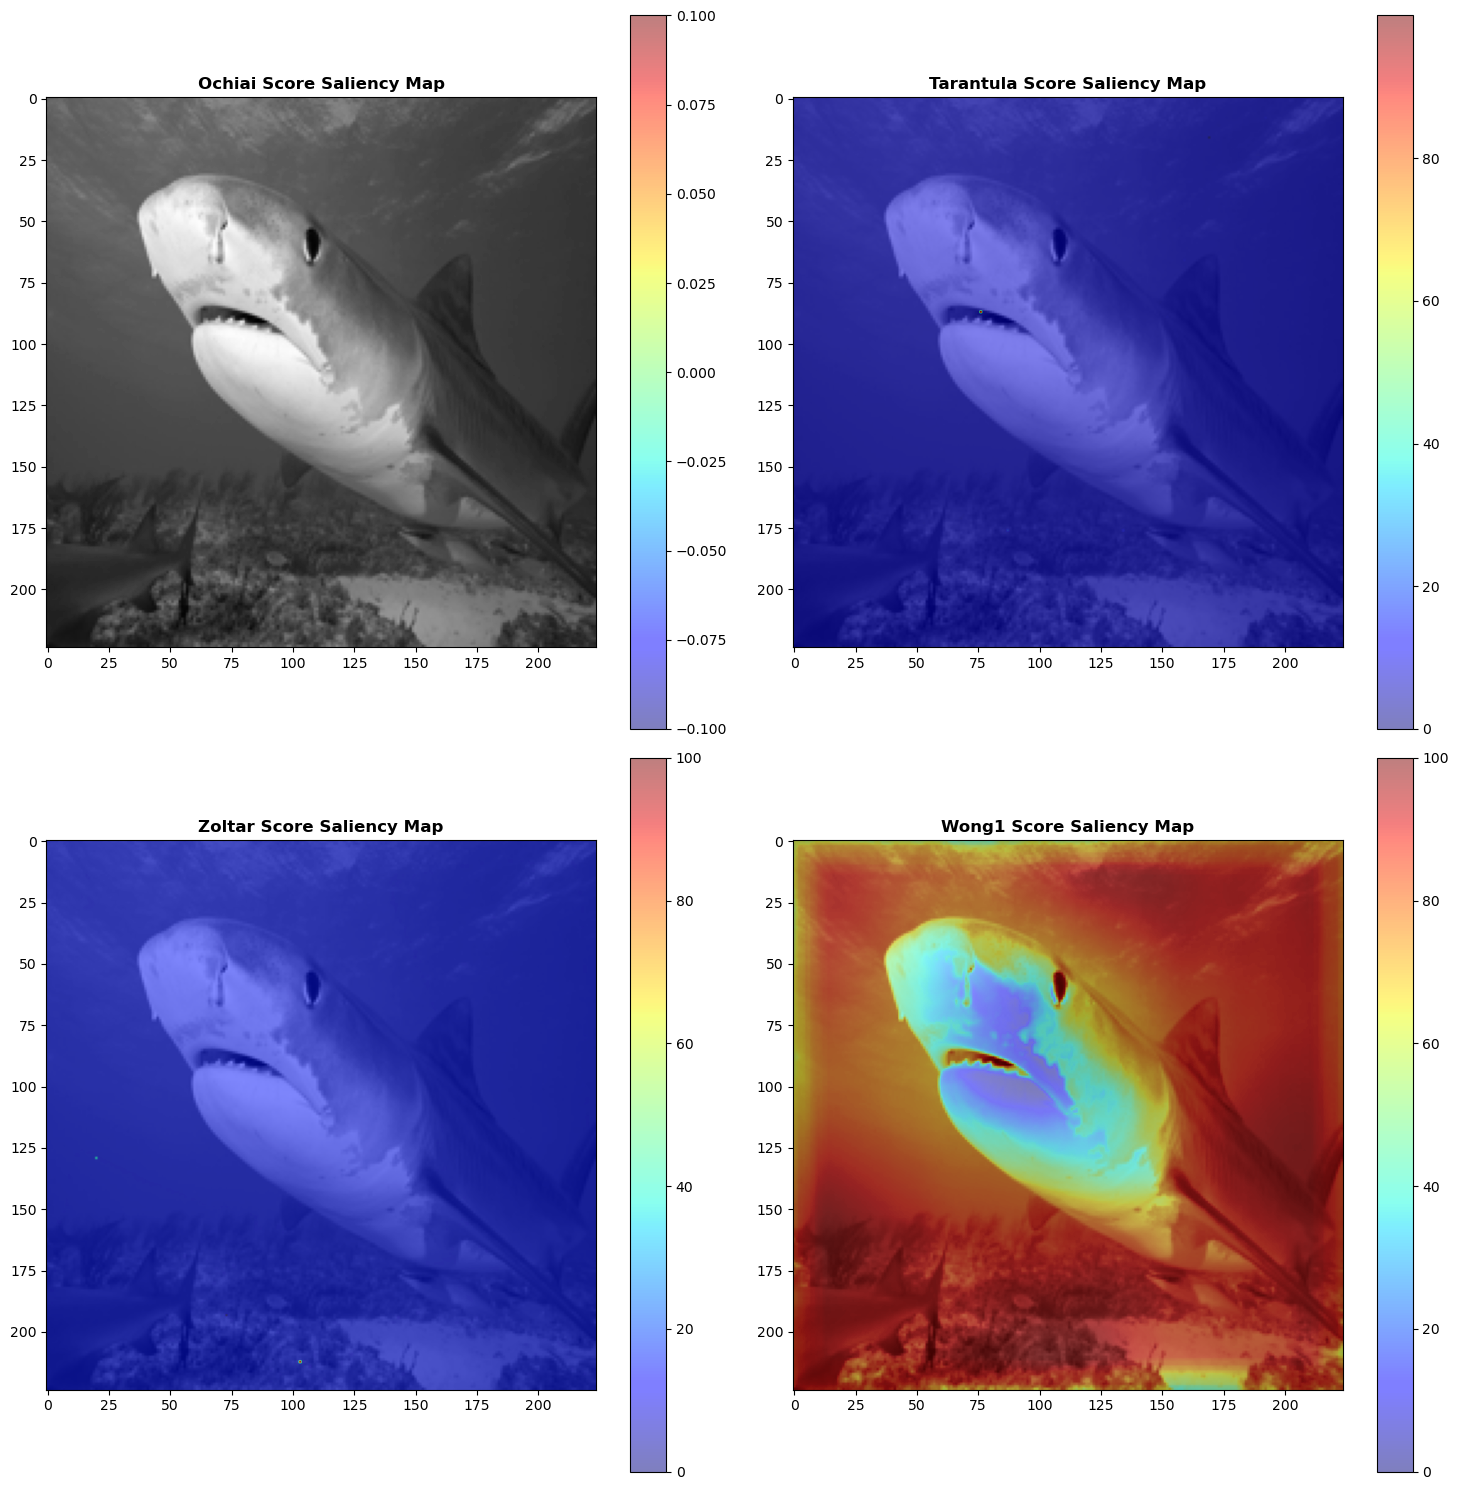

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps and invert their values
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarantula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Invert the values by subtracting from the max value of each map
ochiai_map = ochiai_map.max() - ochiai_map
tarantula_map = tarantula_map.max() - tarantula_map
zoltar_map = zoltar_map.max() - zoltar_map
wong1_map = wong1_map.max() - wong1_map

# Create the figure and subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Define the extent
extent = [0, 224, 0, 224]

# List of maps and titles
maps = [ochiai_map, tarantula_map, zoltar_map, wong1_map]
titles = ['Ochiai Score Saliency Map', 'Tarantula Score Saliency Map', 'Zoltar Score Saliency Map', 'Wong1 Score Saliency Map']

# Plot each map
for ax, saliency_map, title in zip(axs.ravel(), maps, titles):
    # Display the original image
    ax.imshow(original_image_array, cmap='gray')
    
    # Overlay the saliency map
    c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)
    
    # Add a colorbar
    fig.colorbar(c, ax=ax)
    
    # Add title
    ax.set_title(title, fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()


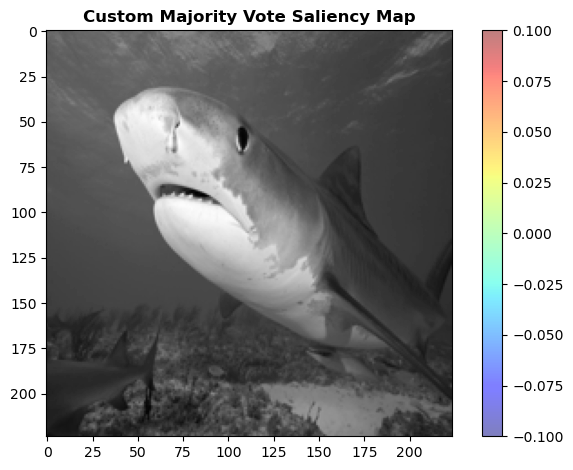

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and resize the original image, and convert to grayscale
original_image = Image.open(img_path).resize((224, 224)).convert('L')  # Replace with your image path
original_image_array = np.array(original_image)

# Prepare the saliency maps and invert their values
ochiai_map = mapped_ochiai_scores.reshape((224, 224))
tarantula_map = mapped_tarauntula_scores.reshape((224, 224))
zoltar_map = mapped_zoltar_scores.reshape((224, 224))
wong1_map = mapped_wong1_scores.reshape((224, 224))

# Invert the values by subtracting from the max value of each map
ochiai_map = ochiai_map.max() - ochiai_map
tarantula_map = tarantula_map.max() - tarantula_map
zoltar_map = zoltar_map.max() - zoltar_map
wong1_map = wong1_map.max() - wong1_map

# Stack the scores for majority voting
all_scores = np.stack((ochiai_map, tarantula_map, zoltar_map, wong1_map), axis=-1)

# Function to apply the custom majority voting logic with weighted sum
def custom_majority_vote(scores):
    # Check if any score is below 20 (high relevance for low scores)
    if np.any(scores < 20):
        weights = np.where(scores < 20, 2, 1)  # Apply higher weight to low scores
        return np.sum(scores * weights) / np.sum(weights)
    # Check if all scores are in the range of 80 to 100, apply weighted sum
    elif np.all(scores >= 80) and np.all(scores <= 100):
        weights = np.where((scores >= 80) & (scores <= 100), 2, 1)  # Apply higher weight to high scores
        return np.sum(scores * weights) / np.sum(weights)
    # Otherwise, use the average of the scores
    else:
        return np.average(scores)

# Apply custom majority voting
custom_scores = np.apply_along_axis(custom_majority_vote, 2, all_scores)

# Reshape the custom scores to match the original image dimensions (not needed if already correct)
saliency_map = custom_scores

# Plot the custom saliency map
fig, ax = plt.subplots()

# Display the original image
ax.imshow(original_image_array, cmap='gray')

# Overlay the saliency map
c = ax.imshow(saliency_map, cmap='jet', alpha=0.5)

# Add a colorbar
fig.colorbar(c, ax=ax)

# Add title
ax.set_title('Custom Majority Vote Saliency Map', fontweight='bold')

# Show the plot
plt.tight_layout()
plt.show()
